In [1]:
# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import osmnx as ox
from src.core import get_processed_osm_data, get_route_graph
from src.parameters import files
from src.population.data_extract import get_extract_population_data
from src.population.downscaling import proportional_population_downscaling
from src.population.utils import population_downscaling_validation, get_aggregated_squares

ox.config(log_file=True,log_console=True, log_name='proportional_downscaling', log_filename='proportional_downscaling', use_cache=True)
figsize = (8,6)

%matplotlib inline

## Define the city to analyse

In [2]:
# City name
city_ref = "Grenoble"
# Grenoble bounding box
north, west, south, east = 45.216932, 5.680504, 45.136750, 5.798655
region_args= {"east":east, "north":north, "south":south, "west":west}

## Retrieve OpenStreetMap data

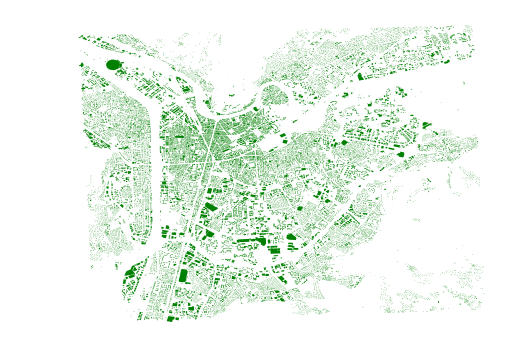

In [3]:
# Retrieve OSM data
df_osm_built, _, _ = get_processed_osm_data(city_ref, region_args=region_args)
# Plot
fig, ax = plt.subplots(figsize=figsize) ; ax.axis('off')
df_osm_built.plot(color='green', ax=ax)

## Gridded population data
* Resolution of 0.04 km^2 (200m x 200m)

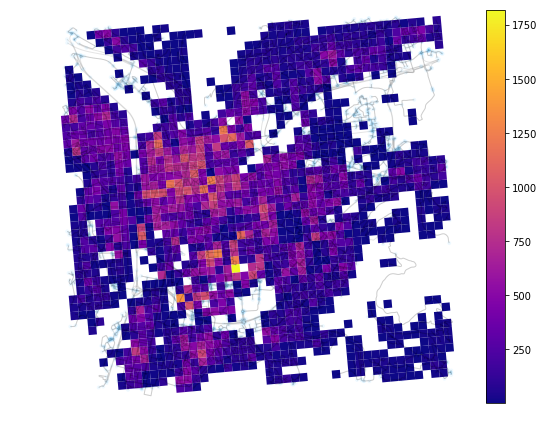

In [4]:
# Population data
df_insee = get_extract_population_data(city_ref=city_ref, data_source="insee", pop_shapefile=files["insee_shapefile"], pop_data_file=files["insee_data_file"], 
                                       to_crs=df_osm_built.crs, df_osm_built=df_osm_built)
# Route graph
G = get_route_graph(city_ref)
# Plot
fig, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.1, node_alpha=0.1)
df_insee.plot("pop_count", ax=ax, cmap='plasma', legend=True)
fig.tight_layout()

## Aggregate gridded population data
* Simulate a resolution of 1km^2

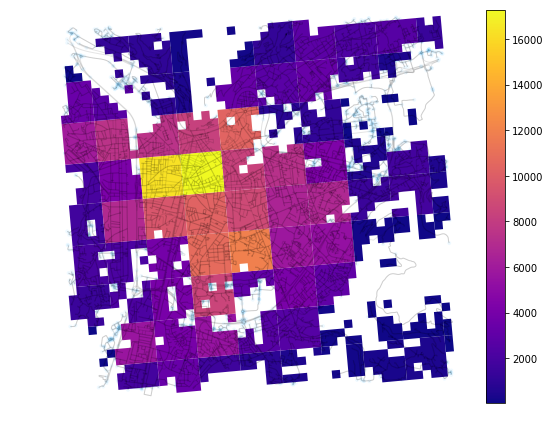

In [5]:
# Get aggregated population data (at GPW's resolution)
df_insee_square_group = get_aggregated_squares(df_insee)
# Plot
fig, ax = ox.plot_graph(G, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.1, node_alpha=0.1)
df_insee_square_group.plot("pop_count", ax=ax, cmap='plasma', legend=True)
fig.tight_layout()

## Population downscaling estimates
* Proportional to the residential surface aggregated on each square

In [6]:
# Downscaling using aggregated squares
%time proportional_population_downscaling(df_osm_built, df_insee_square_group)
# Verify population downscaled within each square
population_downscaling_validation(df_osm_built, df_insee)

CPU times: user 55.4 s, sys: 472 ms, total: 55.9 s
Wall time: 55.8 s


## Population data comparison 
* Projected to latitude-longitude coordinates
* Left: INSEE data (Ground-truth)
* Right: Population downscaling estimation

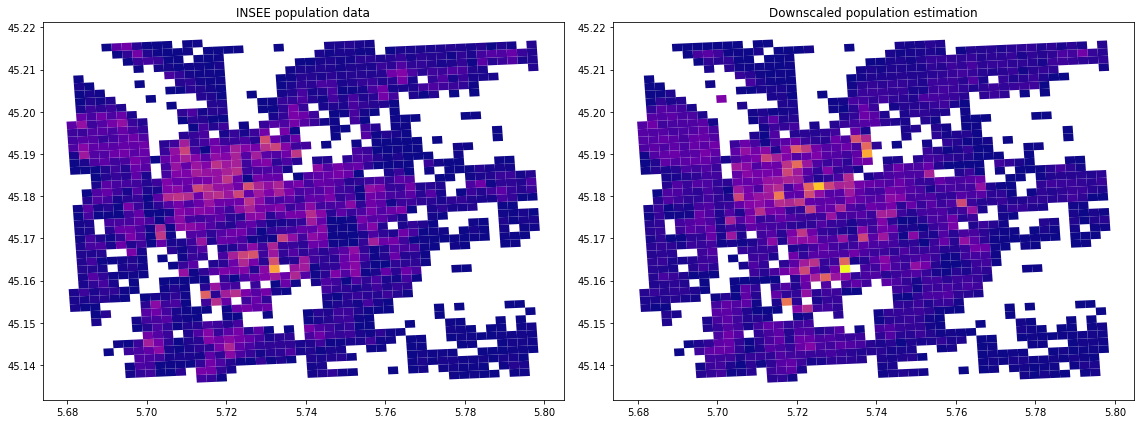

In [7]:
# Plot
fig, axs = plt.subplots(1,2, figsize=(figsize[0] * 2, figsize[1]))
# Title
axs[0].set_title("INSEE population data"); axs[1].set_title("Downscaled population estimation")
vmax = max( df_insee.pop_estimation.max(), df_insee.pop_count.max() )
# Plots
ox.project_gdf(df_insee.copy(), to_latlong=True).plot("pop_count", figsize=figsize, cmap='plasma', ax=axs[0], vmin=0, vmax=vmax)
ox.project_gdf(df_insee.copy(), to_latlong=True).plot("pop_estimation", figsize=figsize, cmap='plasma', ax=axs[1], vmin=0, vmax=vmax)
fig.tight_layout()

## Visualize data frame
* pop_count: Contains the population ground-truth for each gridded square
* pop_estimation: Denotes the estimated population count from the downscaling procedure
* absolute_error: Absolute error between the ground-truth population count and the estimated population count
* relative_error: Relative error of the population estimation procedure

In [8]:
df_insee.loc[ len(df_insee.index)/2 : len(df_insee.index)/2 + 10 ]

,idINSPIRE,pop_count,geometry,pop_estimation,absolute_error,relative_error
index_left,,,,,,
701,CRS3035RES200mN2461200E3983400,517.0,"POLYGON ((712898.9751370181 5006007.898184853,...",969.082923,452.082923,0.874435
702,CRS3035RES200mN2461200E3983600,631.5,"POLYGON ((713097.9296108019 5006026.095916806,...",559.961785,71.538215,0.113283
703,CRS3035RES200mN2461200E3983800,581.0,"POLYGON ((713296.8743178437 5006044.293607658,...",505.223638,75.776362,0.130424
704,CRS3035RES200mN2461200E3984000,367.0,"POLYGON ((713495.8291614931 5006062.481072069,...",157.340511,209.659489,0.571279
705,CRS3035RES200mN2461200E3984200,216.0,"POLYGON ((713694.7843306414 5006080.678400298,...",154.365797,61.634203,0.285344
706,CRS3035RES200mN2461200E3984400,691.0,"POLYGON ((713893.7397319544 5006098.875594044,...",1108.603787,417.603787,0.604347
707,CRS3035RES200mN2461200E3984600,854.5,"POLYGON ((714092.6853672224 5006117.072746903,...",415.535094,438.964906,0.513710
708,CRS3035RES200mN2461200E3984800,544.5,"POLYGON ((714291.641139851 5006135.259673419, ...",432.532334,111.967666,0.205634
709,CRS3035RES200mN2461200E3985000,514.0,"POLYGON ((714490.5972387495 5006153.456463981,...",880.711706,366.711706,0.713447


## Relative error

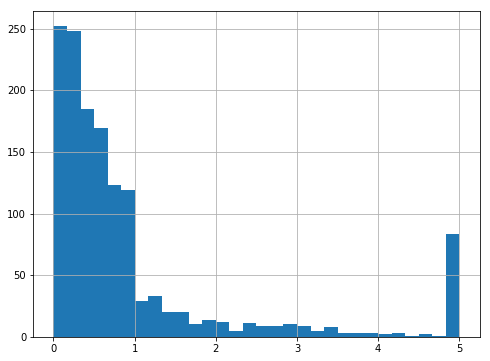

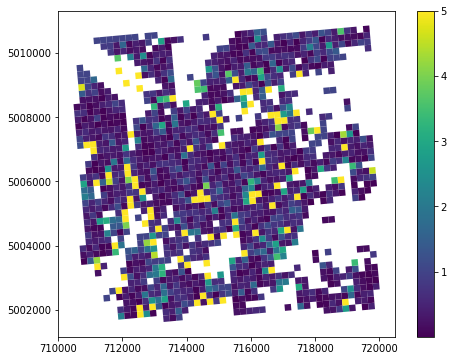

In [9]:
# Bins for error plots
num_bins = 30
# Truncate max relative error for visualization purpose
max_rel_err = 5.
df_insee.loc[ df_insee.relative_error > max_rel_err , "relative_error"] = max_rel_err
# Relative error histogram
df_insee.relative_error.hist(bins=num_bins, figsize=figsize, grid=True)
# Relative error plot
df_insee.plot( 'relative_error', figsize=figsize, legend=True )

## Absolute error

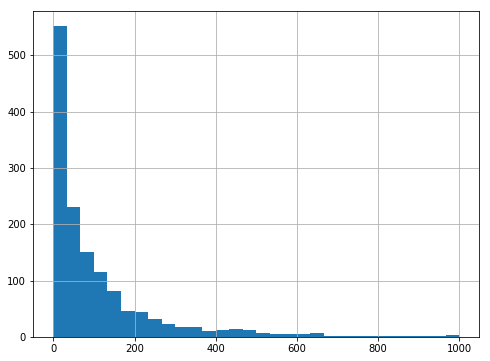

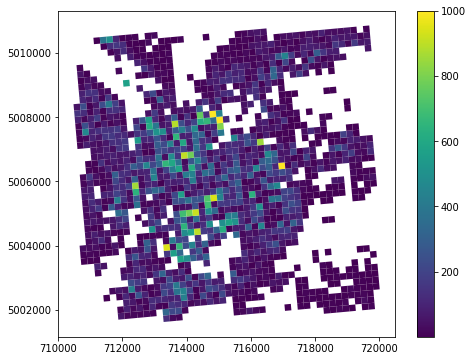

In [10]:
# Truncate max absolute error for visualization purpose
max_abs_err = 1000
df_insee.loc[ df_insee.absolute_error > max_abs_err , "absolute_error"] = max_abs_err
# Absolute error histogram
num_bins = 30
df_insee.absolute_error.hist(bins=num_bins, figsize=figsize, grid=True)
# Absolute error plot
df_insee.plot( 'absolute_error', figsize=figsize, legend=True )